<h2>Importing Libraries

In [1]:
import os


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as k_back
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    from core.yolov4 import YOLO, decode, compute_loss, decode_train  #inset this code here
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU
Physical devices cannot be modified after being initialized


<h2>Creating DenseNet121

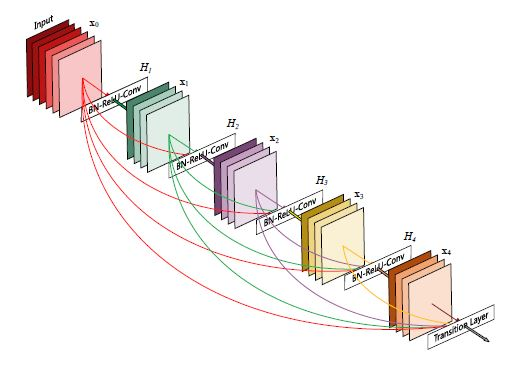
Figure 1: A dense block with 5 layers and growth rate 4<b><br>
from G. Huang, Z. Liu, van, and Weinberger, Kilian Q, “Densely Connected Convolutional Networks,” arXiv.org, 2016. arxiv.org/abs/1608.06993.

Function for sequence after input in convolutional block


In [4]:
def batch_relu_conv2(x,filters,kernel=1,strides=1):
        
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
    return x

Dense Block Function

In [5]:
def dense_block(x, repetition, filters = 32):
        
   for _ in range(repetition):
        y = batch_relu_conv2(x, 4*filters)
        y = batch_relu_conv2(y, filters, 3)
        x = concatenate([y,x])
   return x

Transition Layer Function

In [6]:
def transition_layer(x):
        
        x = batch_relu_conv2(x, k_back.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

Collecting all pieces and to return model


In [7]:
def densenet(input_shape, n_classes, filter = 32):
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition, filter)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    #output = Dense(n_classes, activation = 'softmax')(x)
    output = Dense(n_classes, activation='sigmoid')(x)
    model = Model(input, output)
    return model

<h2> Checking dataset info

In [8]:
s1, s2 = 0, 0
for i in os.listdir("real_vs_fake/real-vs-fake/"):
    s1 += len(os.listdir("real_vs_fake/real-vs-fake/"+i+"/fake"))
    s2 += len(os.listdir("real_vs_fake/real-vs-fake/"+i+"/real"))
                
print(str(s1) + " fake images.")
print(str(s1) + " real images.")

70000 fake images.
70000 real images.


<h2>Preprocessing

In [9]:
image_sz = 224
batch_size = 32
data_generator = ImageDataGenerator(horizontal_flip=True)
path = "real_vs_fake/real-vs-fake/"

# Augment training data 
train_generator = data_generator.flow_from_directory(path+"train/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=True)

# Augment validation data 
val_generator = data_generator.flow_from_directory(path+"valid/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


<h2>Creating model using functions for Densenet

In [10]:
# model = input_shape = 224,224,1
# n_classes = 1
# model = densenet(input_shape,n_classes)


In [11]:
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# model.summary()

In [12]:
gpus = tf.config.list_physical_devices('GPU')
print(tf.test.gpu_device_name())
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

/device:GPU:0
Virtual devices cannot be modified after being initialized


<!-- training_steps= train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=1.0000e-09,model='auto')

callbacks = [PlotLossesKeras(), reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = val_generator,
    validation_steps = (20000//100),
    epochs = 10,
) -->

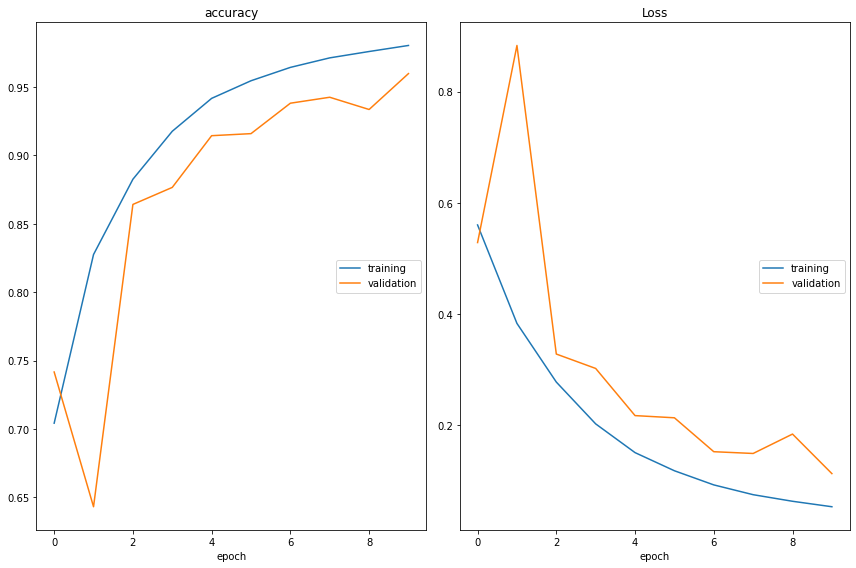

accuracy
	training         	 (min:    0.704, max:    0.980, cur:    0.980)
	validation       	 (min:    0.643, max:    0.960, cur:    0.960)
Loss
	training         	 (min:    0.053, max:    0.560, cur:    0.053)
	validation       	 (min:    0.113, max:    0.883, cur:    0.113)

Epoch 10: saving model to model_weights.h5
3125/3125 [==============================] - 913s 292ms/step - loss: 0.0535 - accuracy: 0.9804 - val_loss: 0.1130 - val_accuracy: 0.9598 - lr: 0.0010


In [13]:
from tensorflow.keras.applications import DenseNet121
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=1.0000e-09,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    train_generator, 
    steps_per_epoch = (100000//batch_size),
    validation_data = val_generator,
    validation_steps = (20000//batch_size),
    epochs = 10,
        callbacks=callbacks
)

In [14]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

<h2>
    Testing

In [21]:
# Augment test data 
test_generator = data_generator.flow_from_directory(path+"test/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)
y_pred = model.predict(test_generator)
y_test = test_generator.classes



Found 20000 images belonging to 2 classes.


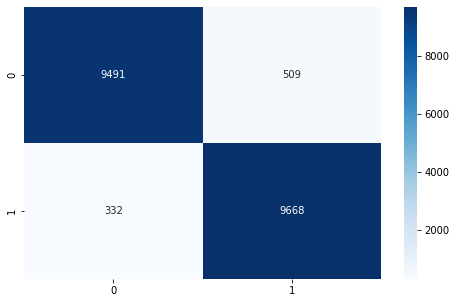

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [23]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.9925629699999999
AP Score: 0.9921041612372011
